# Model 2: ConvNeXt-V2 (Pretrained Transfer Learning)

## 1. Setup & Data Loading

In [1]:
# Standard libraries
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Optuna for hyperparameter tuning
import optuna

# Transfer learning library
import timm

# Visualization libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Project modules
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

# Import dataset
from src.data.pose_dataset import ClassificationDataset

# Import shared utilities (Relevant code in src/utils.py)
from src.utils import (
    # Training
    MetricsTracker,
    train_epoch,
    validate_epoch,
    collect_predictions,
    EarlyStopping,
    # Data
    create_stratified_splits,
    create_dataloaders,
    get_class_mappings,
    # Visualization
    plot_training_curves,
    plot_confusion_matrices,
    plot_per_class_performance,
    plot_optuna_results,
    plot_feature_maps,
    plot_grad_cam,
    plot_embedding_tsne,
    # Evaluation
    compute_metrics,
    compute_computational_cost,
    print_model_summary,
    generate_classification_report
)

# Set device
# Determine the device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

# Set seeds for reproducibility
torch.manual_seed(42)
import numpy as np
np.random.seed(42)

print("All libraries and utilities imported successfully")

Using device: mps
All libraries and utilities imported successfully


### Load Dataset & Create Splits

In [52]:
# Load full dataset
data_root = project_root / 'data'
full_dataset = ClassificationDataset(rootpath=str(data_root), augment=False)

print(f"Total samples: {len(full_dataset)}")
print(f"Pitch classes: {len(full_dataset.p_dict)}")
print(f"Roll classes: {len(full_dataset.r_dict)}")
print(f"\nPitch mapping: {full_dataset.p_dict}")
print(f"Roll mapping: {full_dataset.r_dict}")

Total samples: 2000
Pitch classes: 18
Roll classes: 7

Pitch mapping: {'P0': 0, 'P10': 1, 'P15': 2, 'P25': 3, 'P30': 4, 'P35': 5, 'P40': 6, 'P45': 7, 'P50': 8, 'P55': 9, 'P5': 10, 'P60': 11, 'P65': 12, 'P70': 13, 'P75': 14, 'P80': 15, 'P85': 16, 'P90': 17}
Roll mapping: {'R0': 0, 'R15': 1, 'R30': 2, 'R45': 3, 'R5': 4, 'R10': 5, 'R60': 6}


In [53]:
# Use utility function for stratified splits (REPLACES manual split code)
train_idx, val_idx, test_idx = create_stratified_splits(
    dataset=full_dataset,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    random_state=42
)

print(f"\nSplit sizes:")
print(f"   Train: {len(train_idx)} ({len(train_idx)/len(full_dataset)*100:.1f}%)")
print(f"   Val:   {len(val_idx)} ({len(val_idx)/len(full_dataset)*100:.1f}%)")
print(f"   Test:  {len(test_idx)} ({len(test_idx)/len(full_dataset)*100:.1f}%)")


Split sizes:
   Train: 1200 (60.0%)
   Val:   400 (20.0%)
   Test:  400 (20.0%)


In [32]:
# Create dataset splits with augmentation for training
train_dataset = ClassificationDataset(rootpath=str(data_root), augment=True, random_ratio=0.5)
val_dataset = ClassificationDataset(rootpath=str(data_root), augment=False)
test_dataset = ClassificationDataset(rootpath=str(data_root), augment=False)

# Use utility function for dataloader creation (REPLACES manual DataLoader code)
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    train_indices=train_idx,
    val_indices=val_idx,
    test_indices=test_idx,
    batch_size=16,  # Smaller batch size for ConvNeXt-V2
    num_workers=0,  # MPS-optimized
    pin_memory=False  # MPS-optimized
)

# Get class mappings (NEW utility function)
mappings = get_class_mappings(full_dataset)

print("Datasets and loaders created")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")
print(f"   Pitch classes: {mappings['num_pitch_classes']}")
print(f"   Roll classes: {mappings['num_roll_classes']}")

Datasets and loaders created
   Train batches: 75
   Val batches: 25
   Test batches: 25
   Pitch classes: 18
   Roll classes: 7


## 2. Model Architecture

In [33]:
class ConvNeXtV2DualHead(nn.Module):
    """
    ConvNeXt-V2 with dual-head architecture for pose classification

    Uses pretrained ConvNeXt-V2 Tiny as feature extractor with custom dual heads
    for pitch and roll angle classification.

    Args:
        num_pitch_classes: Number of pitch angle classes
        num_roll_classes: Number of roll angle classes
        pretrained: Use pretrained weights from timm
        freeze_backbone: Freeze backbone weights during training
        dropout_rate: Dropout probability in classification heads
    """

    def __init__(
        self,
        num_pitch_classes=18,
        num_roll_classes=7,
        pretrained=True,
        freeze_backbone=False,
        dropout_rate=0.3
    ):
        super(ConvNeXtV2DualHead, self).__init__()

        # Load pretrained ConvNeXt-V2 Tiny (feature dimension = 768)
        self.backbone = timm.create_model(
            'convnextv2_tiny.fcmae_ft_in1k',
            pretrained=pretrained,
            num_classes=0  # Remove classification head
        )

        # Feature dimension from ConvNeXt-V2 Tiny
        self.feature_dim = 768

        # Optionally freeze backbone
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # Pitch classification head
        self.pitch_head = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_pitch_classes)
        )

        # Roll classification head
        self.roll_head = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_roll_classes)
        )

        # Initialize classification heads
        self._initialize_heads()

    def _initialize_heads(self):
        """Initialize weights for classification heads"""
        for head in [self.pitch_head, self.roll_head]:
            for m in head.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)

    def forward(self, x, return_features=False):
        """
        Forward pass

        Args:
            x: Input tensor of shape (batch_size, 3, H, W)
            return_features: If True, return features along with predictions

        Returns:
            pitch_out: Pitch predictions (batch_size, num_pitch_classes)
            roll_out: Roll predictions (batch_size, num_roll_classes)
            features: (optional) Feature embeddings (batch_size, feature_dim)
        """
        # Extract features using backbone
        features = self.backbone(x)

        # Dual head predictions
        pitch_out = self.pitch_head(features)
        roll_out = self.roll_head(features)

        if return_features:
            return pitch_out, roll_out, features
        else:
            return pitch_out, roll_out

    def unfreeze_backbone(self):
        """Unfreeze backbone for fine-tuning"""
        for param in self.backbone.parameters():
            param.requires_grad = True

    def freeze_backbone(self):
        """Freeze backbone weights"""
        for param in self.backbone.parameters():
            param.requires_grad = False

## 3. Training (Baseline)

In [34]:
print("Just to remember: Training utilities ready (imported from src.utils)")
print("  - MetricsTracker: Track metrics across epochs")
print("  - train_epoch: Train for one epoch")
print("  - validate_epoch: Validate for one epoch")
print("  - collect_predictions: Collect predictions for analysis")

Just to remember: Training utilities ready (imported from src.utils)
  - MetricsTracker: Track metrics across epochs
  - train_epoch: Train for one epoch
  - validate_epoch: Validate for one epoch
  - collect_predictions: Collect predictions for analysis


In [35]:
# Baseline hyperparameters
BASELINE_CONFIG = {
    'batch_size': 16,
    'lr': 1e-4,
    'epochs': 100,
    'dropout_rate': 0.3,
    'freeze_backbone': False,  # Fine-tune entire model
    'weight_decay': 1e-4
}

# Data loaders already created using create_dataloaders() utility in cell-6!
# No need to create them again here

print(f"Baseline configuration set")
print(f"   Batch size: {BASELINE_CONFIG['batch_size']}")
print(f"   Learning rate: {BASELINE_CONFIG['lr']}")
print(f"   Epochs: {BASELINE_CONFIG['epochs']}")
print(f"   Freeze backbone: {BASELINE_CONFIG['freeze_backbone']}")

Baseline configuration set
   Batch size: 16
   Learning rate: 0.0001
   Epochs: 100
   Freeze backbone: False


In [36]:
# Initialize baseline model
baseline_model = ConvNeXtV2DualHead(
    num_pitch_classes=len(full_dataset.p_dict),
    num_roll_classes=len(full_dataset.r_dict),
    pretrained=True,
    freeze_backbone=BASELINE_CONFIG['freeze_backbone'],
    dropout_rate=BASELINE_CONFIG['dropout_rate']
).to(device)

# Loss functions
criterion_pitch = nn.CrossEntropyLoss()
criterion_roll = nn.CrossEntropyLoss()

# Optimizer (AdamW for transformer-based models)
optimizer = torch.optim.AdamW(
    baseline_model.parameters(),
    lr=BASELINE_CONFIG['lr'],
    weight_decay=BASELINE_CONFIG['weight_decay']
)

# Learning rate scheduler
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10)

# Metrics tracker
baseline_tracker = MetricsTracker()

print(f"Baseline ConvNeXt-V2 model initialized")
print(f"   Pretrained: ImageNet-1K (FCMAE)")
print(f"   Backbone frozen: {BASELINE_CONFIG['freeze_backbone']}")
print(f"   Device: {device}")

Baseline ConvNeXt-V2 model initialized
   Pretrained: ImageNet-1K (FCMAE)
   Backbone frozen: False
   Device: mps


### Training

In [ ]:
# Training loop
print("Baseline training\n")

best_val_acc = 0
patience = 10
patience_counter = 0

for epoch in range(1, BASELINE_CONFIG['epochs'] + 1):
    # Train
    train_metrics = train_epoch(
        baseline_model, train_loader,
        criterion_pitch, criterion_roll,
        optimizer, device
    )

    # Validate
    val_metrics = validate_epoch(
        baseline_model, val_loader,
        criterion_pitch, criterion_roll,
        device
    )

    # Update scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Track metrics
    baseline_tracker.update({
        'train_loss': train_metrics['loss'],
        'train_pitch_loss': train_metrics['pitch_loss'],
        'train_roll_loss': train_metrics['roll_loss'],
        'train_pitch_acc': train_metrics['pitch_acc'],
        'train_roll_acc': train_metrics['roll_acc'],
        'val_loss': val_metrics['loss'],
        'val_pitch_loss': val_metrics['pitch_loss'],
        'val_roll_loss': val_metrics['roll_loss'],
        'val_pitch_acc': val_metrics['pitch_acc'],
        'val_roll_acc': val_metrics['roll_acc'],
        'lr': current_lr
    })

    # Save best model
    val_acc_avg = (val_metrics['pitch_acc'] + val_metrics['roll_acc']) / 2
    if val_acc_avg > best_val_acc:
        best_val_acc = val_acc_avg
        torch.save(baseline_model.state_dict(), project_root / 'models' / '3_convnextv2_pose.pth')
        patience_counter = 0
    else:
        patience_counter += 1

    # Print progress
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d}/{BASELINE_CONFIG['epochs']}")
        print(f"  Train - Loss: {train_metrics['loss']:.4f} | "
              f"Pitch Acc: {train_metrics['pitch_acc']:.3f} | "
              f"Roll Acc: {train_metrics['roll_acc']:.3f}")
        print(f"  Val   - Loss: {val_metrics['loss']:.4f} | "
              f"Pitch Acc: {val_metrics['pitch_acc']:.3f} | "
              f"Roll Acc: {val_metrics['roll_acc']:.3f}")
        print(f"  LR: {current_lr:.6f}\n")

    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}")
        break

print(f"\nBaseline training completed")
print(f"   Best validation accuracy: {best_val_acc:.4f}")

Baseline training

Epoch 01/100
  Train - Loss: 2.5681 | Pitch Acc: 0.426 | Roll Acc: 0.688
  Val   - Loss: 1.1900 | Pitch Acc: 0.752 | Roll Acc: 0.887
  LR: 0.000098

Epoch 05/100
  Train - Loss: 0.1061 | Pitch Acc: 0.984 | Roll Acc: 0.989
  Val   - Loss: 0.1152 | Pitch Acc: 0.978 | Roll Acc: 0.980
  LR: 0.000050

Epoch 10/100
  Train - Loss: 0.0171 | Pitch Acc: 1.000 | Roll Acc: 1.000
  Val   - Loss: 0.0653 | Pitch Acc: 0.988 | Roll Acc: 0.985
  LR: 0.000100

Epoch 15/100
  Train - Loss: 0.0211 | Pitch Acc: 1.000 | Roll Acc: 0.996
  Val   - Loss: 0.0374 | Pitch Acc: 0.990 | Roll Acc: 0.993
  LR: 0.000050

Epoch 20/100
  Train - Loss: 0.0043 | Pitch Acc: 1.000 | Roll Acc: 1.000
  Val   - Loss: 0.0351 | Pitch Acc: 0.993 | Roll Acc: 0.998
  LR: 0.000100

Epoch 25/100
  Train - Loss: 0.0018 | Pitch Acc: 1.000 | Roll Acc: 1.000
  Val   - Loss: 0.0271 | Pitch Acc: 0.990 | Roll Acc: 0.998
  LR: 0.000050

Epoch 30/100
  Train - Loss: 0.0015 | Pitch Acc: 1.000 | Roll Acc: 1.000
  Val   - Loss

In [ ]:
baseline_model.load_state_dict(torch.load(project_root / 'models' / '3_convnextv2_pose.pth'))
print("Best baseline model loaded")

Best baseline model loaded


## 4. Evaluation & Error Analysis

### 4.1 Training Dynamics Visualization

### 4.2 Test Set Evaluation

In [ ]:
# Load best model
baseline_model.load_state_dict(torch.load(project_root / 'models' / '3_convnextv2_pose.pth'))
baseline_model.eval()

print("Best baseline model loaded for test evaluation")

Best baseline model loaded for test evaluation


In [55]:
test_predictions = collect_predictions(
    model=baseline_model,
    dataloader=test_loader,
    device=device
)

# Compute metrics
test_metrics = compute_metrics(
    test_predictions
)



In [56]:
test_metrics

{'pitch': {'accuracy': 0.9975,
  'precision': 0.9977272727272728,
  'recall': 0.9975,
  'f1_score': 0.9975505310037684},
 'roll': {'accuracy': 0.9975,
  'precision': 0.9975609756097561,
  'recall': 0.9975,
  'f1_score': 0.9974942456580875}}

In [48]:
print("\n" + "="*70)
print("BASELINE MODEL - TEST SET PERFORMANCE")
print("="*70)
print(f"Pitch Accuracy: {test_metrics['pitch']['accuracy']:.4f}")
print(f"Roll Accuracy:  {test_metrics['roll']['accuracy']:.4f}")
print(f"Average Accuracy: {(test_metrics['pitch']['accuracy']+ test_metrics['roll']['accuracy'])/2}")
print("="*70)


BASELINE MODEL - TEST SET PERFORMANCE
Pitch Accuracy: 0.9975
Roll Accuracy:  0.9975
Average Accuracy: 0.9975


### 4.3 Confusion Matrices

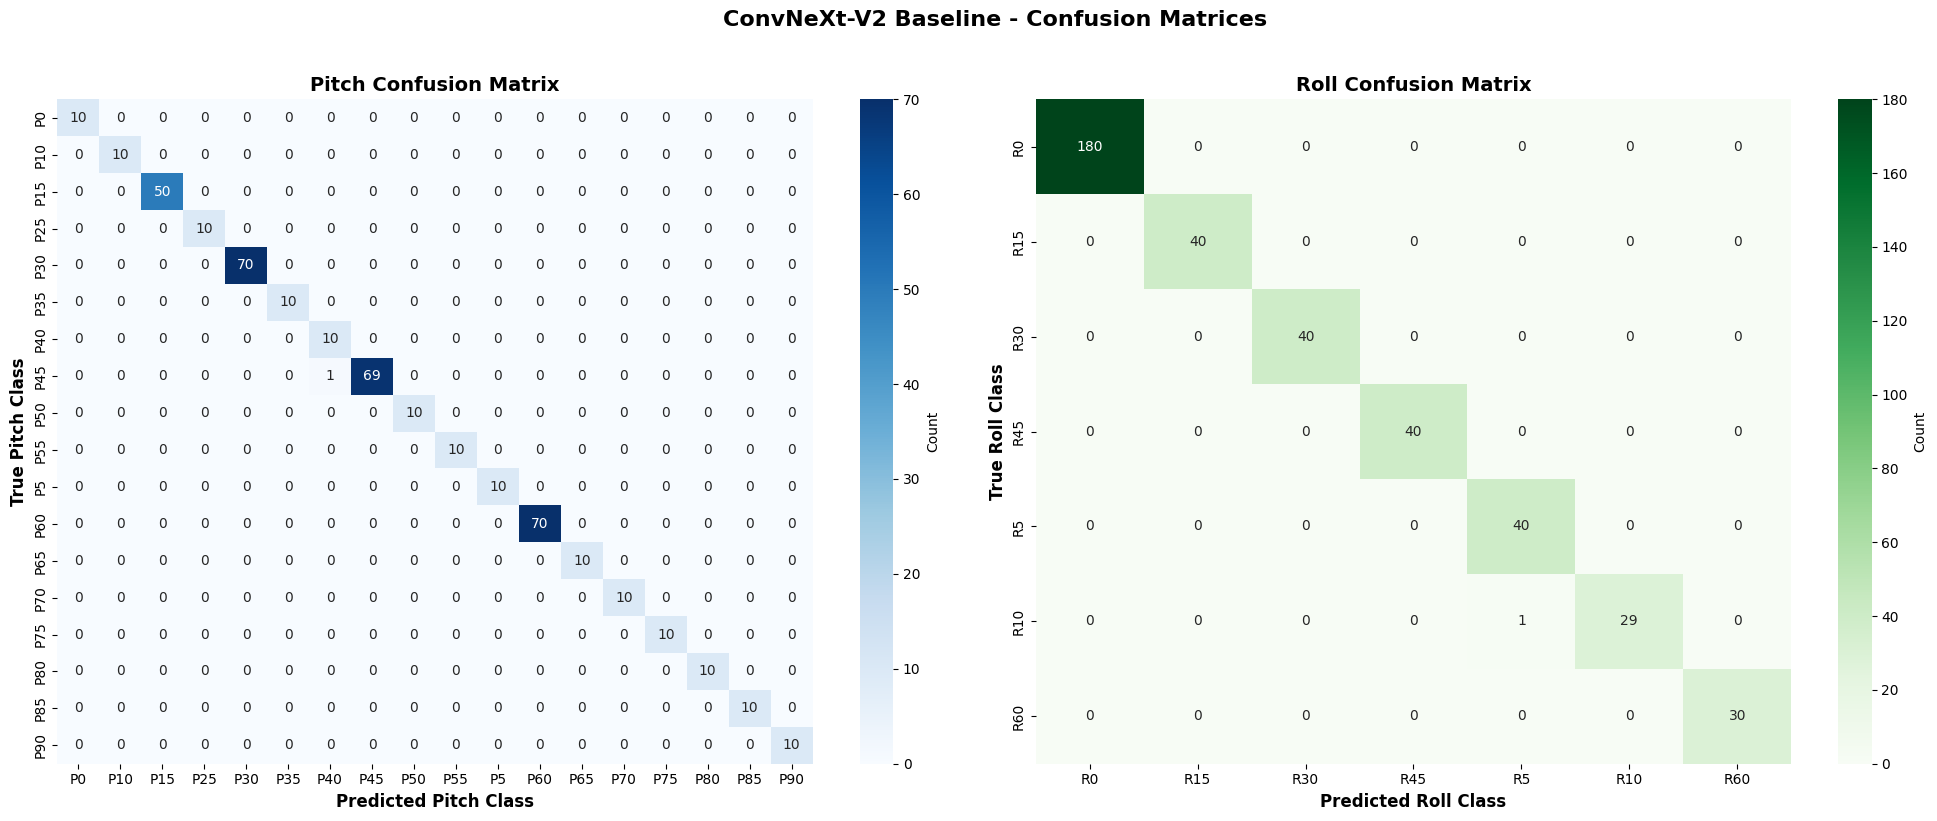

Confusion matrices plotted


In [58]:
# Get class names
pitch_names = [k for k, v in sorted(full_dataset.p_dict.items(), key=lambda x: x[1])]
roll_names = [k for k, v in sorted(full_dataset.r_dict.items(), key=lambda x: x[1])]

# Plot confusion matrices
plot_confusion_matrices(
    predictions=test_predictions,
    class_names_pitch=pitch_names,
    class_names_roll=roll_names,
    save_path=project_root / 'reports' / '4_convnextv2_baseline_confusion_matrices.png',
    title='ConvNeXt-V2 Baseline - Confusion Matrices'
)

print("Confusion matrices plotted")

### 4.4 Per-Class Performance Analysis

In [50]:
# Use utility function for classification reports (REPLACES manual reporting)
pitch_report, roll_report = generate_classification_report(
    predictions=test_predictions,
    class_names_pitch=pitch_names,
    class_names_roll=roll_names
)

print("\n" + "="*70)
print("PITCH CLASSIFICATION REPORT")
print("="*70)
print(pitch_report)

print("\n" + "="*70)
print("ROLL CLASSIFICATION REPORT")
print("="*70)
print(roll_report)


PITCH CLASSIFICATION REPORT
              precision    recall  f1-score   support

          P0       1.00      1.00      1.00        10
         P10       1.00      1.00      1.00        10
         P15       1.00      1.00      1.00        50
         P25       1.00      1.00      1.00        10
         P30       1.00      1.00      1.00        70
         P35       1.00      1.00      1.00        10
         P40       0.91      1.00      0.95        10
         P45       1.00      0.99      0.99        70
         P50       1.00      1.00      1.00        10
         P55       1.00      1.00      1.00        10
          P5       1.00      1.00      1.00        10
         P60       1.00      1.00      1.00        70
         P65       1.00      1.00      1.00        10
         P70       1.00      1.00      1.00        10
         P75       1.00      1.00      1.00        10
         P80       1.00      1.00      1.00        10
         P85       1.00      1.00      1.00        1

### Final Evaluation & Comparison

### Optimized Model: Additional Visualizations

### 7.1 Systematic Error Analysis

In [59]:
# Use analyze_errors utility to identify systematic misclassification patterns
from src.utils import analyze_errors

error_analysis = analyze_errors(
    predictions=test_predictions,
    class_names_pitch=pitch_names,
    class_names_roll=roll_names,
    top_k=10
)

print("="*70)
print("SYSTEMATIC ERROR ANALYSIS")
print("="*70)

print(f"\nOverall Error Rates:")
print(f"   Pitch Error Rate: {error_analysis['pitch_error_rate']*100:.2f}%")
print(f"   Roll Error Rate: {error_analysis['roll_error_rate']*100:.2f}%")
print(f"   Total Misclassified (Pitch): {len(error_analysis['pitch_error_indices'])}/{len(test_predictions['pitch_labels'])}")
print(f"   Total Misclassified (Roll): {len(error_analysis['roll_error_indices'])}/{len(test_predictions['roll_labels'])}")

print(f"\nTop 10 Most Confused Pitch Class Pairs:")
for i, pair in enumerate(error_analysis['pitch_confusion_pairs'][:10], 1):
    print(f"   {i}. {pair['true_class']} -> {pair['pred_class']}: {pair['count']} errors")

print(f"\nTop 10 Most Confused Roll Class Pairs:")
for i, pair in enumerate(error_analysis['roll_confusion_pairs'][:10], 1):
    print(f"   {i}. {pair['true_class']} -> {pair['pred_class']}: {pair['count']} errors")

print(f"\nLow Confidence Predictions (Pitch):")
low_conf_pitch_indices = error_analysis['low_confidence_pitch'][:5]
for idx in low_conf_pitch_indices:
    true_label = test_predictions['pitch_labels'][idx]
    pred_label = test_predictions['pitch_preds'][idx]
    confidence = test_predictions['pitch_probs'][idx].max()
    print(f"   Sample {idx}: True={pitch_names[true_label]}, Pred={pitch_names[pred_label]}, Conf={confidence:.3f}")

print(f"\nLow Confidence Predictions (Roll):")
low_conf_roll_indices = error_analysis['low_confidence_roll'][:5]
for idx in low_conf_roll_indices:
    true_label = test_predictions['roll_labels'][idx]
    pred_label = test_predictions['roll_preds'][idx]
    confidence = test_predictions['roll_probs'][idx].max()
    print(f"   Sample {idx}: True={roll_names[true_label]}, Pred={roll_names[pred_label]}, Conf={confidence:.3f}")

SYSTEMATIC ERROR ANALYSIS

Overall Error Rates:
   Pitch Error Rate: 0.25%
   Roll Error Rate: 0.25%
   Total Misclassified (Pitch): 1/400
   Total Misclassified (Roll): 1/400

Top 10 Most Confused Pitch Class Pairs:
   1. P45 -> P40: 1 errors

Top 10 Most Confused Roll Class Pairs:
   1. R10 -> R5: 1 errors

Low Confidence Predictions (Pitch):
   Sample 357: True=P40, Pred=P40, Conf=0.657
   Sample 84: True=P85, Pred=P85, Conf=0.681
   Sample 178: True=P60, Pred=P60, Conf=0.864
   Sample 388: True=P0, Pred=P0, Conf=0.885
   Sample 307: True=P45, Pred=P40, Conf=0.899

Low Confidence Predictions (Roll):
   Sample 154: True=R5, Pred=R5, Conf=0.604
   Sample 100: True=R5, Pred=R5, Conf=0.757
   Sample 66: True=R10, Pred=R10, Conf=0.916
   Sample 338: True=R10, Pred=R10, Conf=0.970
   Sample 180: True=R10, Pred=R10, Conf=0.985


### 7.2 Error Distribution Histograms

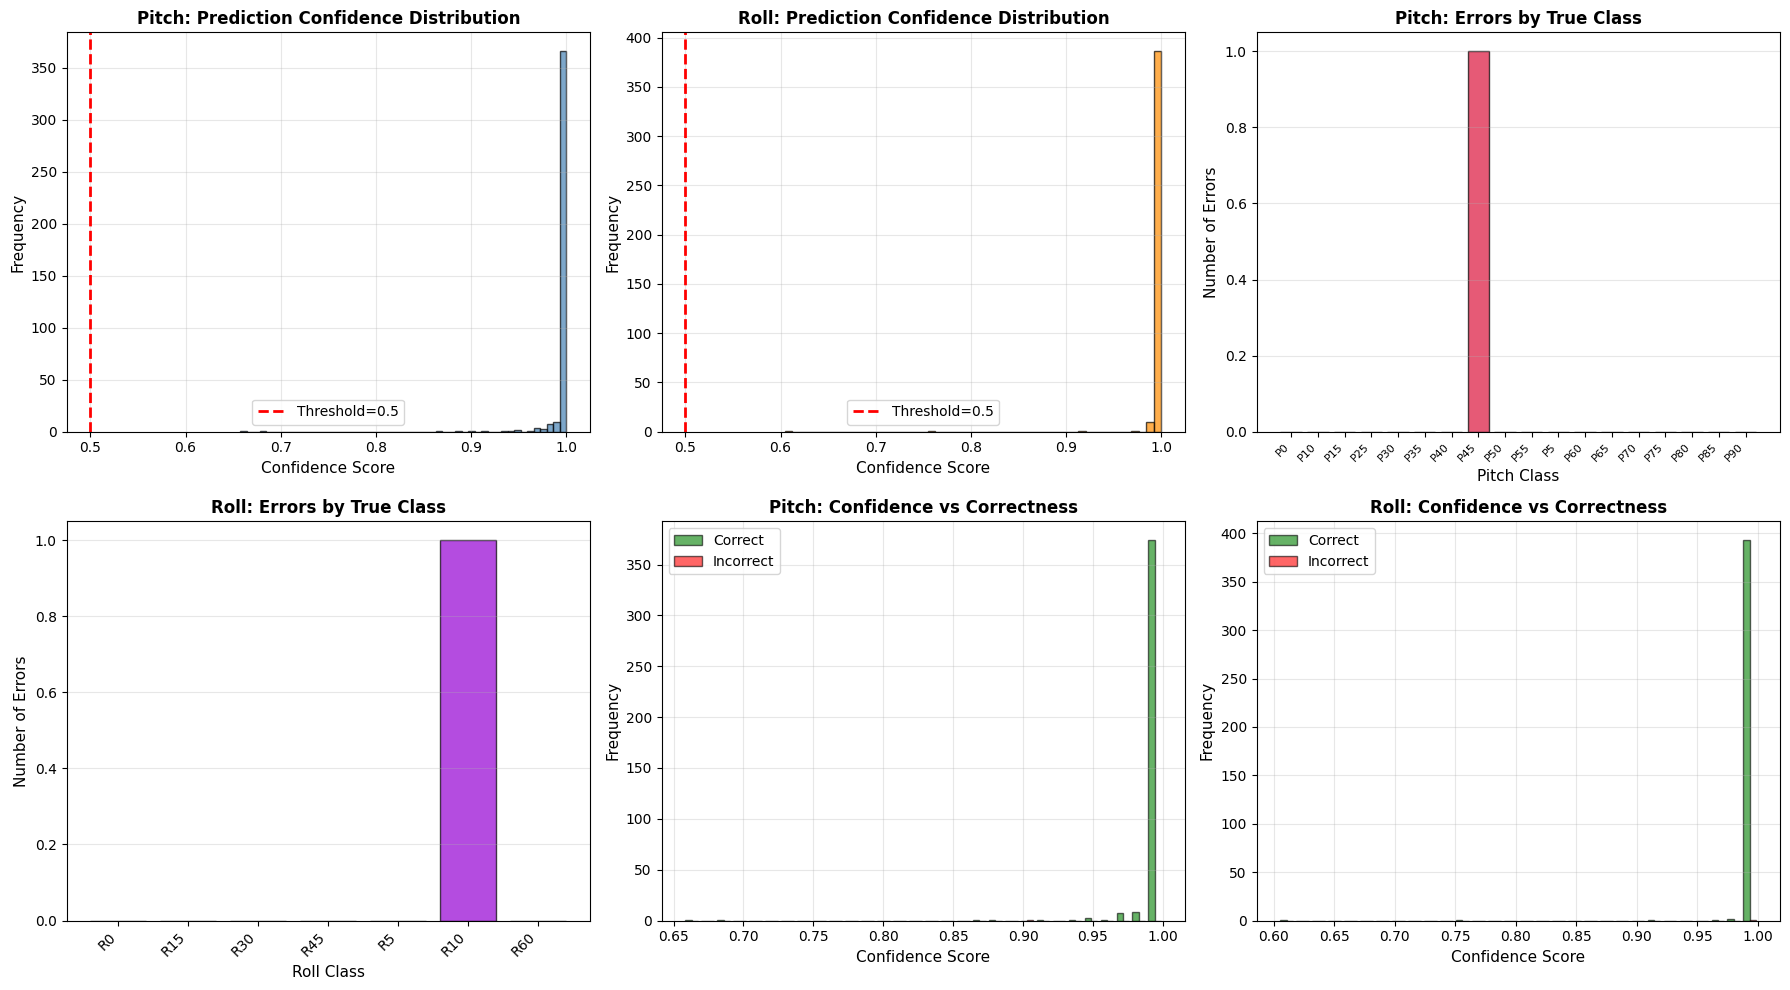

Error distribution histograms created


In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Create error distribution visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Pitch prediction confidence histogram
axes[0, 0].hist(test_predictions['pitch_probs'].max(axis=1), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold=0.5')
axes[0, 0].set_xlabel('Confidence Score', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Pitch: Prediction Confidence Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Roll prediction confidence histogram
axes[0, 1].hist(test_predictions['roll_probs'].max(axis=1), bins=50, color='darkorange', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold=0.5')
axes[0, 1].set_xlabel('Confidence Score', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Roll: Prediction Confidence Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Errors by pitch class
pitch_error_counts = np.zeros(len(pitch_names))
for idx in error_analysis['pitch_error_indices']:
    pitch_error_counts[test_predictions['pitch_labels'][idx]] += 1
axes[0, 2].bar(range(len(pitch_names)), pitch_error_counts, color='crimson', edgecolor='black', alpha=0.7)
axes[0, 2].set_xlabel('Pitch Class', fontsize=11)
axes[0, 2].set_ylabel('Number of Errors', fontsize=11)
axes[0, 2].set_title('Pitch: Errors by True Class', fontsize=12, fontweight='bold')
axes[0, 2].set_xticks(range(len(pitch_names)))
axes[0, 2].set_xticklabels(pitch_names, rotation=45, ha='right', fontsize=8)
axes[0, 2].grid(alpha=0.3, axis='y')

# 4. Errors by roll class
roll_error_counts = np.zeros(len(roll_names))
for idx in error_analysis['roll_error_indices']:
    roll_error_counts[test_predictions['roll_labels'][idx]] += 1
axes[1, 0].bar(range(len(roll_names)), roll_error_counts, color='darkviolet', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Roll Class', fontsize=11)
axes[1, 0].set_ylabel('Number of Errors', fontsize=11)
axes[1, 0].set_title('Roll: Errors by True Class', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(range(len(roll_names)))
axes[1, 0].set_xticklabels(roll_names, rotation=45, ha='right')
axes[1, 0].grid(alpha=0.3, axis='y')

# 5. Confidence vs Correctness (Pitch)
correct_mask_pitch = test_predictions['pitch_preds'] == test_predictions['pitch_labels']
correct_conf_pitch = test_predictions['pitch_probs'].max(axis=1)[correct_mask_pitch]
incorrect_conf_pitch = test_predictions['pitch_probs'].max(axis=1)[~correct_mask_pitch]
axes[1, 1].hist([correct_conf_pitch, incorrect_conf_pitch], bins=30, label=['Correct', 'Incorrect'],
                color=['green', 'red'], alpha=0.6, edgecolor='black')
axes[1, 1].set_xlabel('Confidence Score', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Pitch: Confidence vs Correctness', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# 6. Confidence vs Correctness (Roll)
correct_mask_roll = test_predictions['roll_preds'] == test_predictions['roll_labels']
correct_conf_roll = test_predictions['roll_probs'].max(axis=1)[correct_mask_roll]
incorrect_conf_roll = test_predictions['roll_probs'].max(axis=1)[~correct_mask_roll]
axes[1, 2].hist([correct_conf_roll, incorrect_conf_roll], bins=30, label=['Correct', 'Incorrect'],
                color=['green', 'red'], alpha=0.6, edgecolor='black')
axes[1, 2].set_xlabel('Confidence Score', fontsize=11)
axes[1, 2].set_ylabel('Frequency', fontsize=11)
axes[1, 2].set_title('Roll: Confidence vs Correctness', fontsize=12, fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'reports' / '4_convnextv2_error_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Error distribution histograms created")

### 7.3 Worst Predictions Gallery

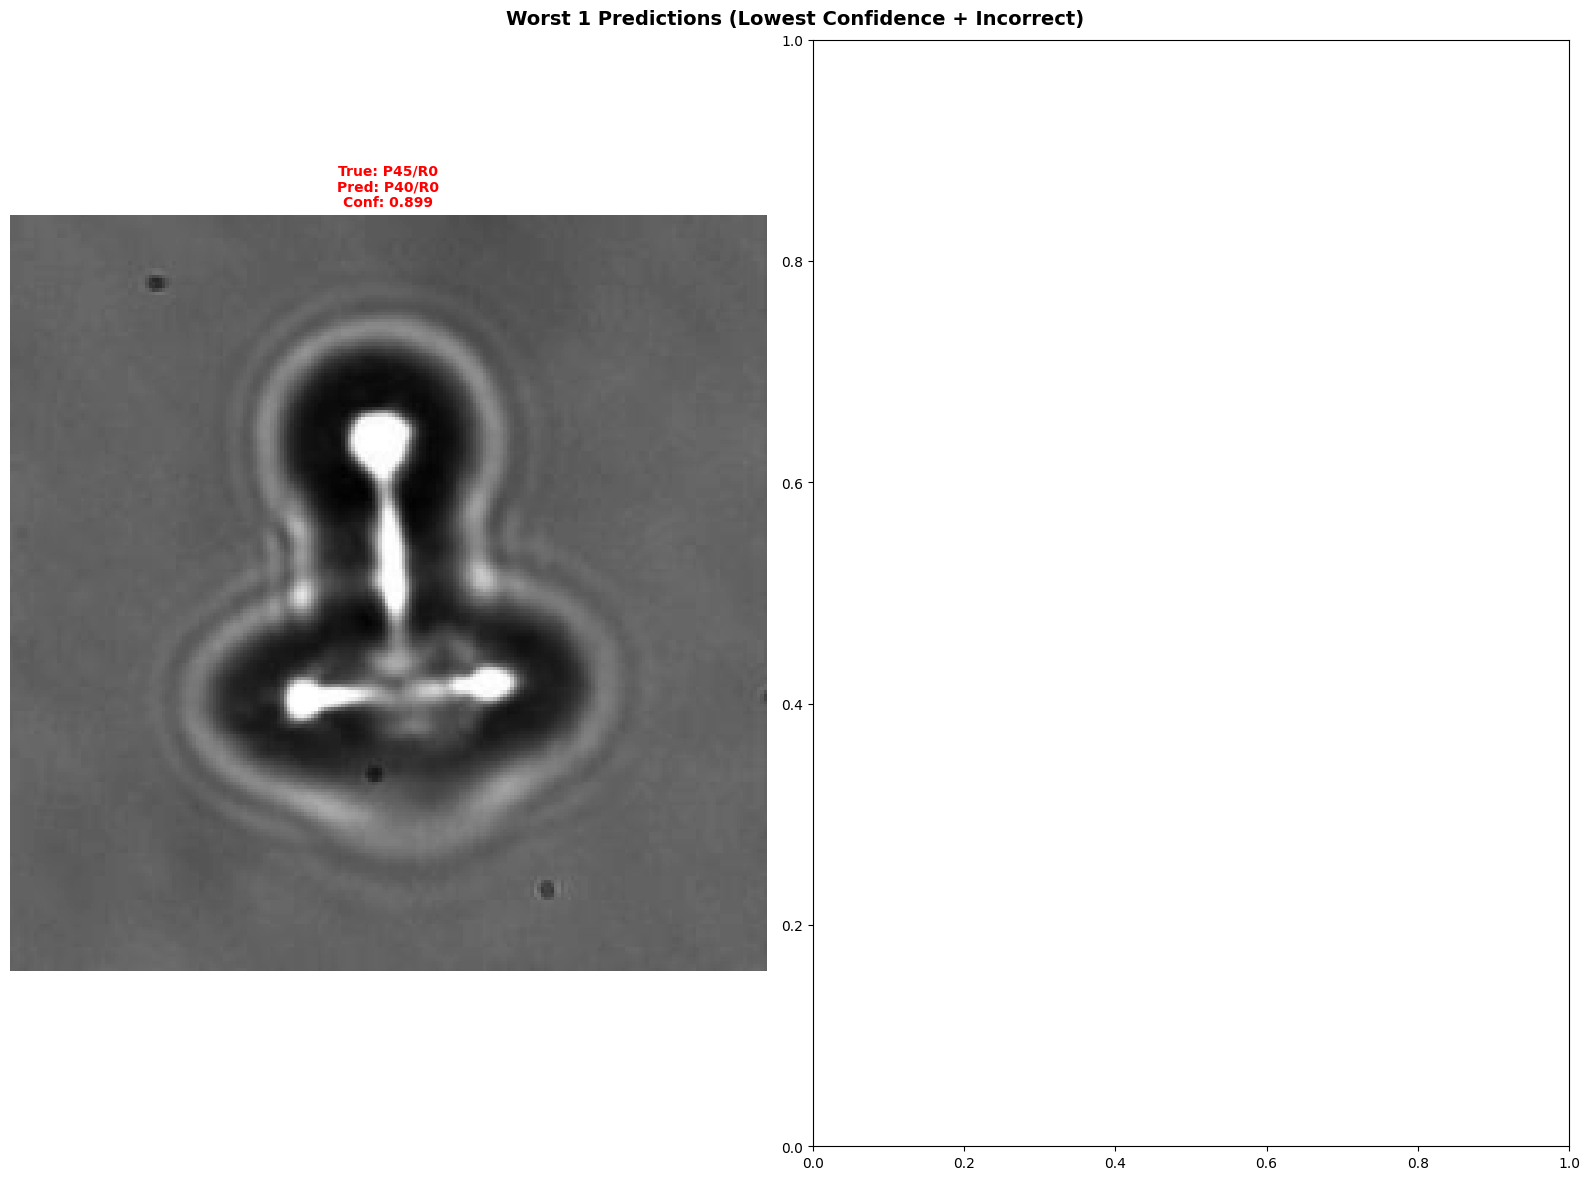

Gallery of 1 worst predictions created


In [63]:
# Visualize worst predictions (lowest confidence + incorrect)
incorrect_pitch = test_predictions['pitch_preds'] != test_predictions['pitch_labels']
incorrect_pitch_indices = np.where(incorrect_pitch)[0]

if len(incorrect_pitch_indices) > 0:
    # Get confidence scores for incorrect predictions
    incorrect_confidences = test_predictions['pitch_probs'][incorrect_pitch_indices].max(axis=1)

    # Sort by confidence (lowest first = worst predictions)
    worst_indices = incorrect_pitch_indices[np.argsort(incorrect_confidences)[:12]]

    # Create gallery
    fig, axes = plt.subplots(1, 2, figsize=(16, 12))
    axes = axes.ravel()

    for i, idx in enumerate(worst_indices):
        # Get image from test dataset
        img, (pitch_label, roll_label) = test_dataset[test_idx[idx]]

        # Denormalize image for display
        img_display = img.permute(1, 2, 0).numpy()
        img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())

        # Get predictions
        true_pitch = pitch_names[test_predictions['pitch_labels'][idx]]
        pred_pitch = pitch_names[test_predictions['pitch_preds'][idx]]
        true_roll = roll_names[test_predictions['roll_labels'][idx]]
        pred_roll = roll_names[test_predictions['roll_preds'][idx]]
        conf = test_predictions['pitch_probs'][idx].max()

        # Display
        axes[i].imshow(img_display)
        axes[i].axis('off')
        axes[i].set_title(f'True: {true_pitch}/{true_roll}\nPred: {pred_pitch}/{pred_roll}\nConf: {conf:.3f}',
                         fontsize=10, color='red', fontweight='bold')

    plt.suptitle(f'Worst {len(worst_indices)} Predictions (Lowest Confidence + Incorrect)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(project_root / 'reports' / '4_convnextv2_worst_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Gallery of {len(worst_indices)} worst predictions created")
else:
    print("No incorrect predictions found!")

### 7.4 Feature Maps Visualization (Convolutional Layers)

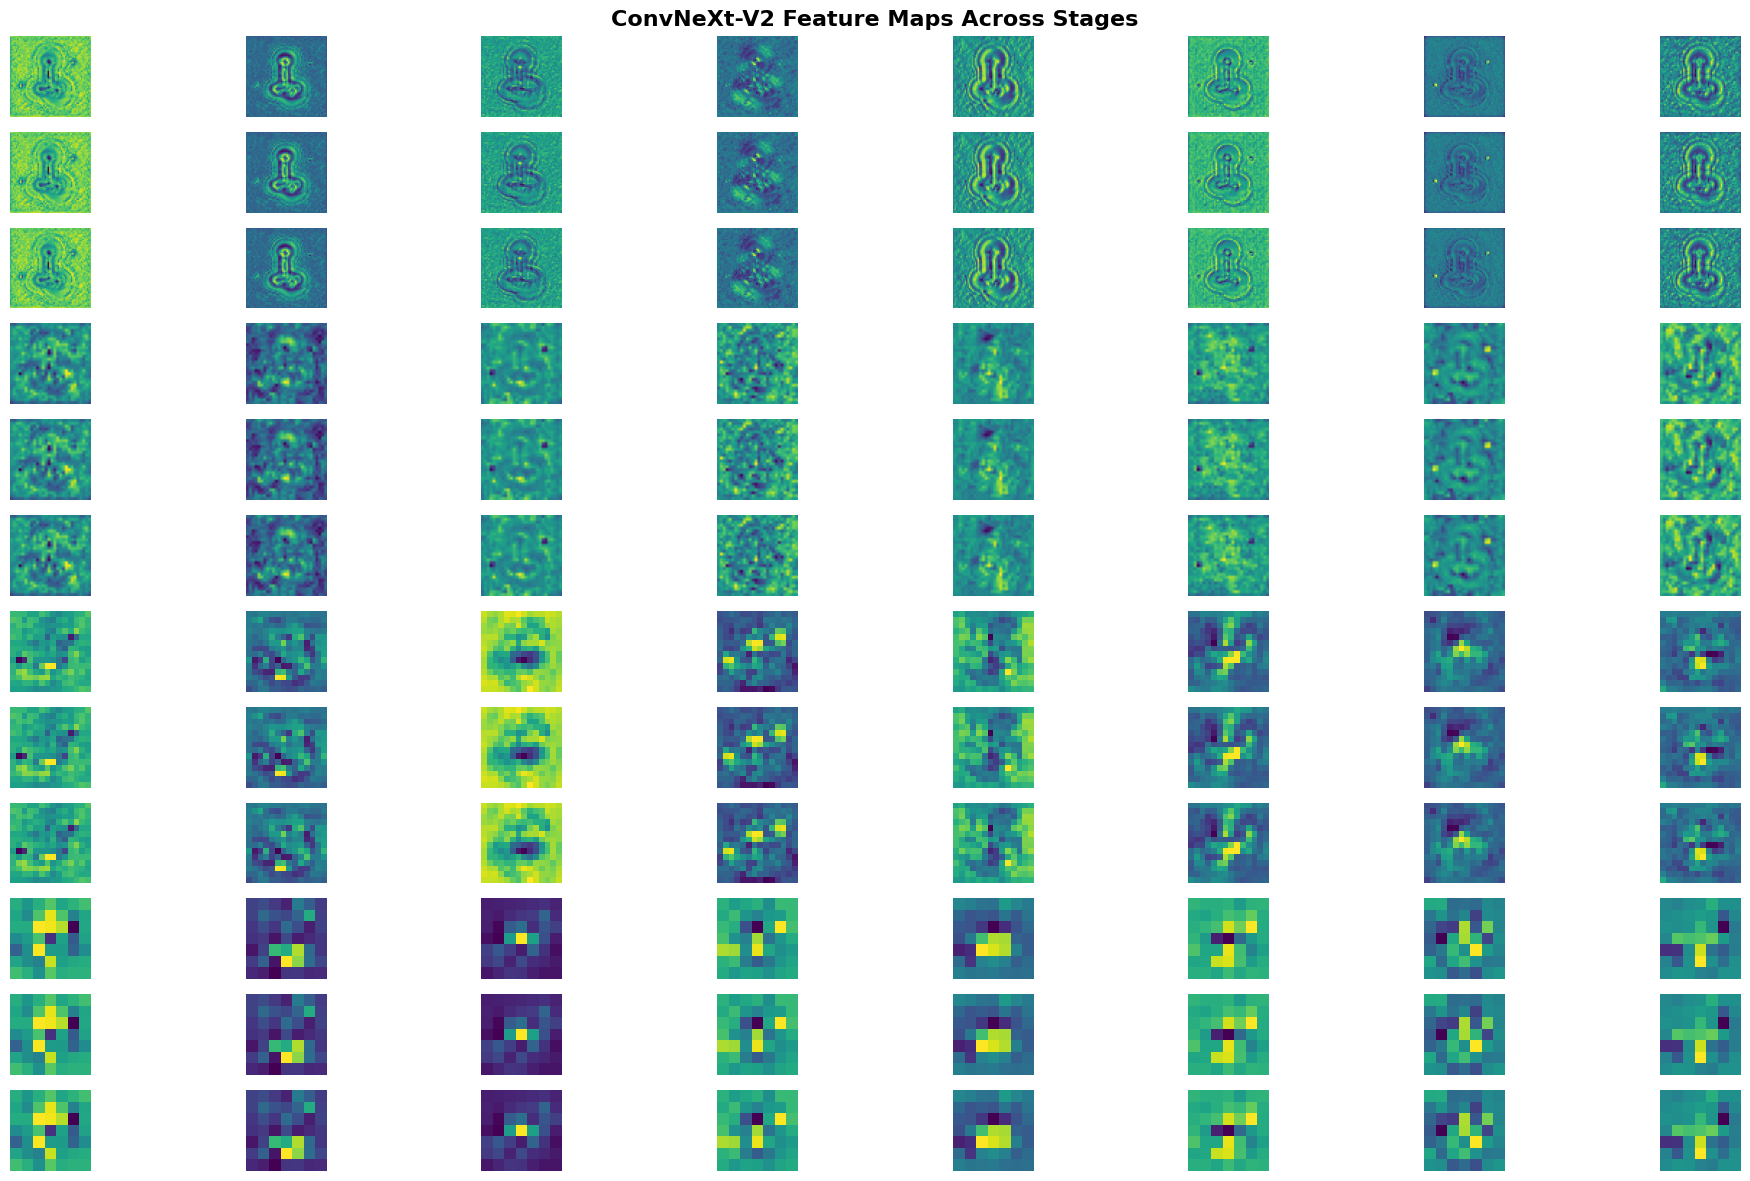

In [83]:
# Get a sample image
sample_idx = 0
sample_img = test_dataset[test_idx[sample_idx]][0].unsqueeze(0).numpy()  # Shape: (1, 3, H, W)
sample_img_tensor = torch.from_numpy(sample_img).to(device)

# Extract feature maps from ConvNeXt-V2 stages
baseline_model.eval()
activations = []

def get_activation(name):
    def hook(module, input, output):
        activations.append(output.detach())
    return hook

# Register hooks for ConvNeXt-V2 stages
hooks = []
for i in range(4):  # ConvNeXt-V2 has 4 stages
    hook = baseline_model.backbone.stages[i].register_forward_hook(get_activation(f'stage{i}'))
    hooks.append(hook)

# Forward pass
with torch.no_grad():
    _ = baseline_model(sample_img_tensor)

# Remove hooks
for hook in hooks:
    hook.remove()

# Visualize feature maps from each stage
fig = plt.figure(figsize=(20, 12))
num_stages = len(activations)

for stage_idx in range(num_stages):
    activation = activations[stage_idx][0].cpu().numpy()  # First sample
    num_channels = min(8, activation.shape[0])  # Show max 8 channels
    
    for ch_idx in range(num_channels):
        ax = plt.subplot(num_stages, 8, stage_idx * 8 + ch_idx + 1)
        
        # Handle different spatial sizes
        if len(activation.shape) == 3:
            feature_map = activation[ch_idx]
        else:
            feature_map = activation[ch_idx].mean(axis=0)
        
        ax.imshow(feature_map, cmap='viridis')
        ax.axis('off')
        if ch_idx == 0:
            ax.set_ylabel(f'Stage {stage_idx+1}', fontweight='bold', fontsize=10)

plt.suptitle('ConvNeXt-V2 Feature Maps Across Stages', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(project_root / 'reports' / '8_convnext_v2_depth_feature_maps.png', dpi=300, bbox_inches='tight')
plt.show()

### 7.5 Grad-CAM Attention Heatmaps

Generating Grad-CAM visualizations for 6 samples...
  Sample 1: True=P30/R5, Pred=P30/R5, Conf=1.000


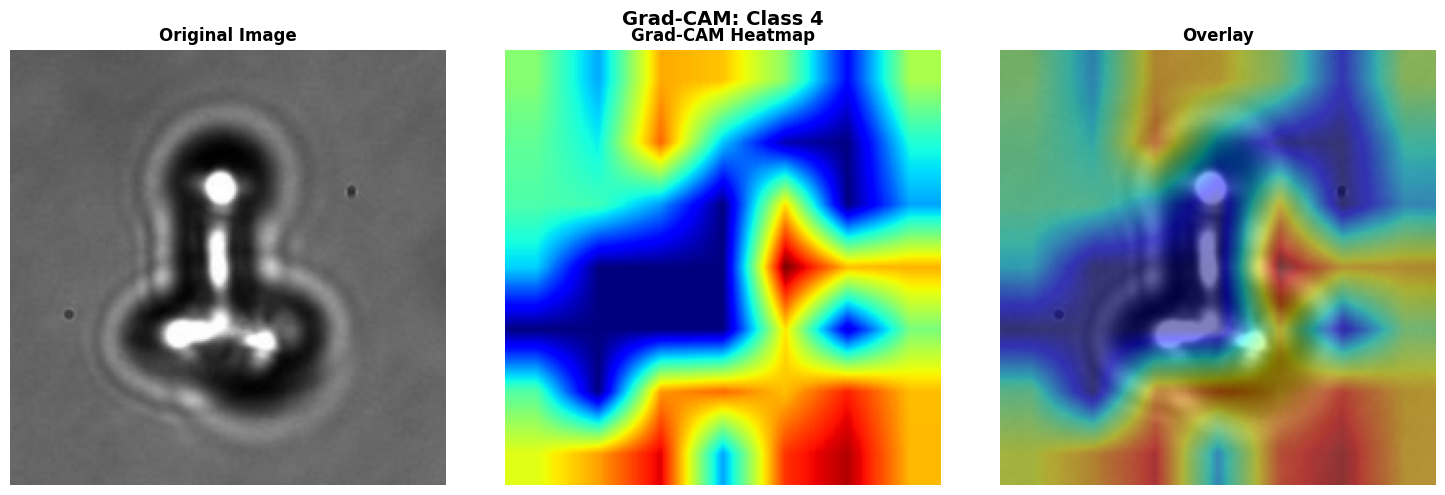

  Sample 2: True=P60/R0, Pred=P60/R0, Conf=0.999


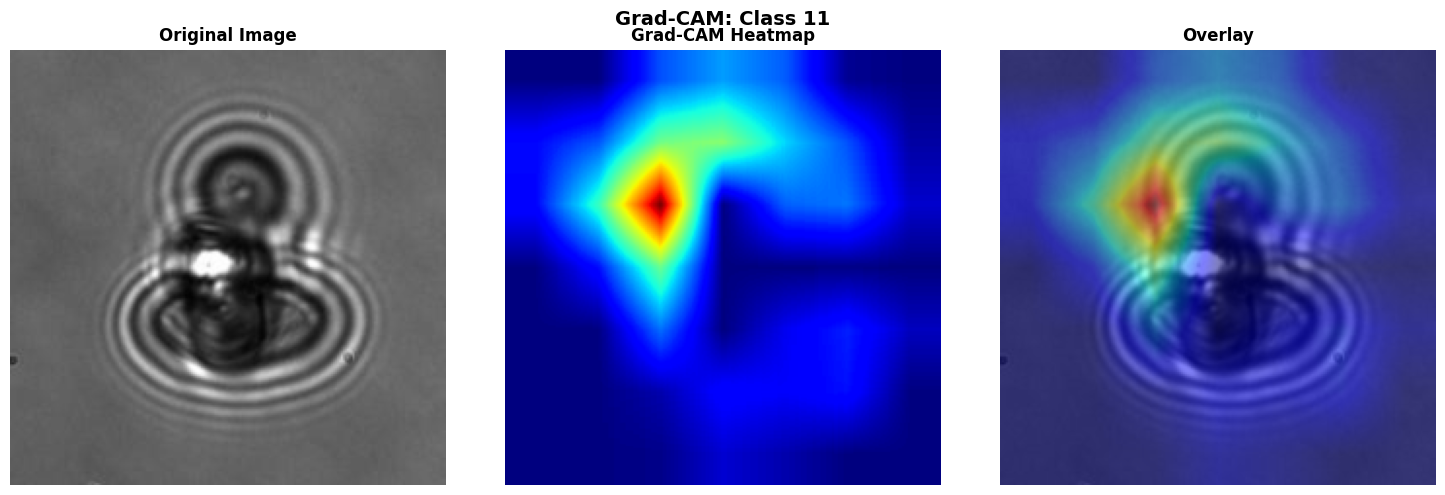

  Sample 3: True=P90/R0, Pred=P90/R0, Conf=0.994


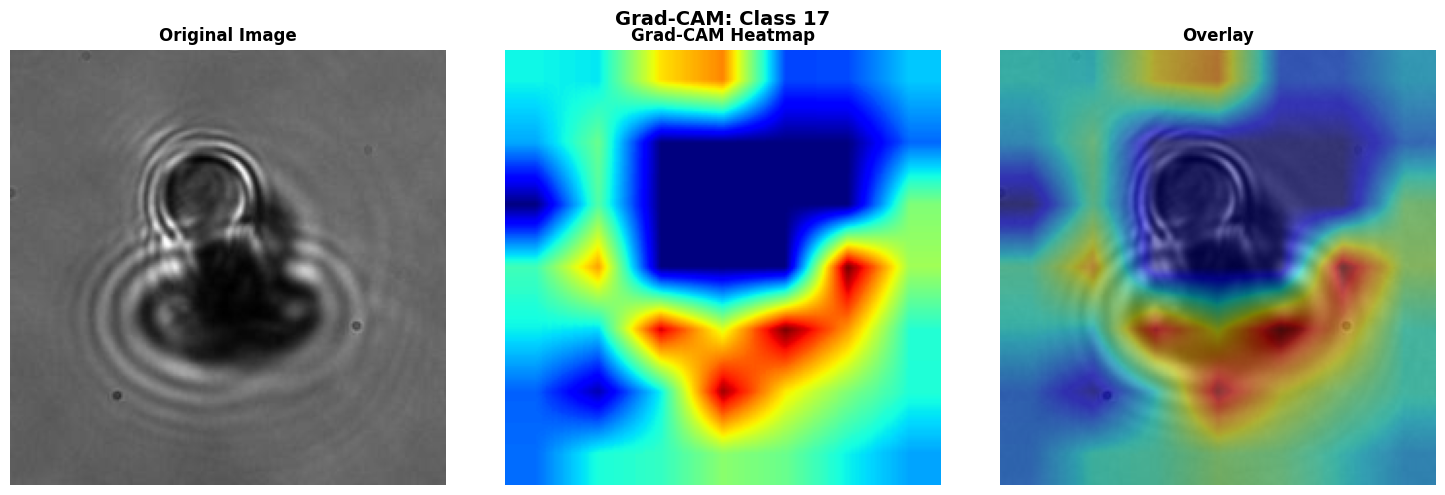

  Sample 4: True=P45/R5, Pred=P45/R5, Conf=0.999


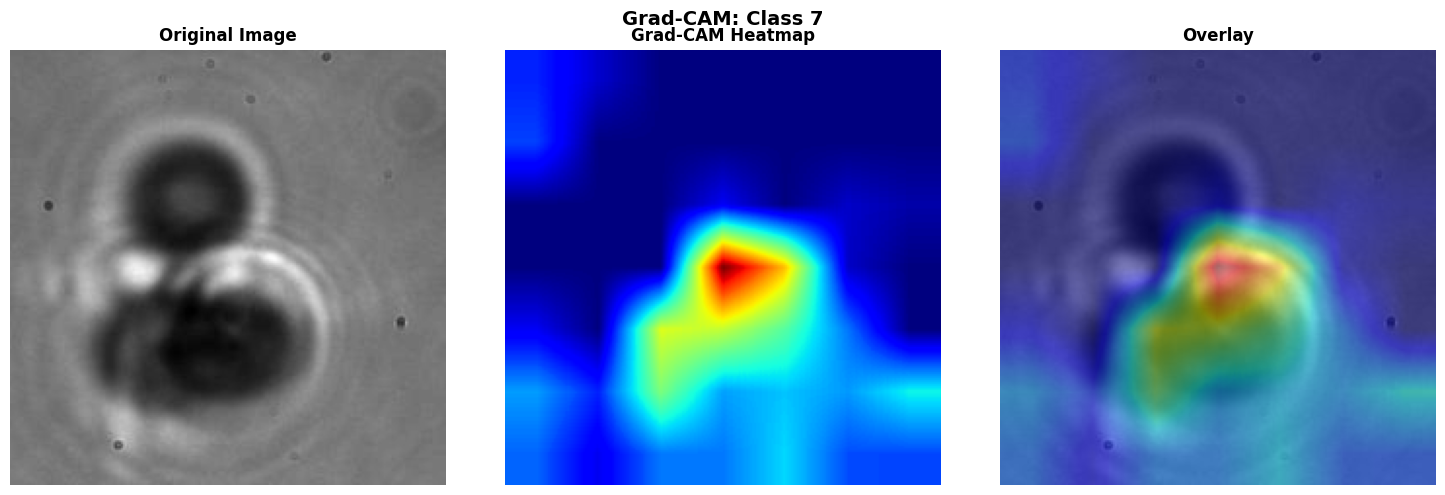

  Sample 5: True=P40/R0, Pred=P40/R0, Conf=0.997


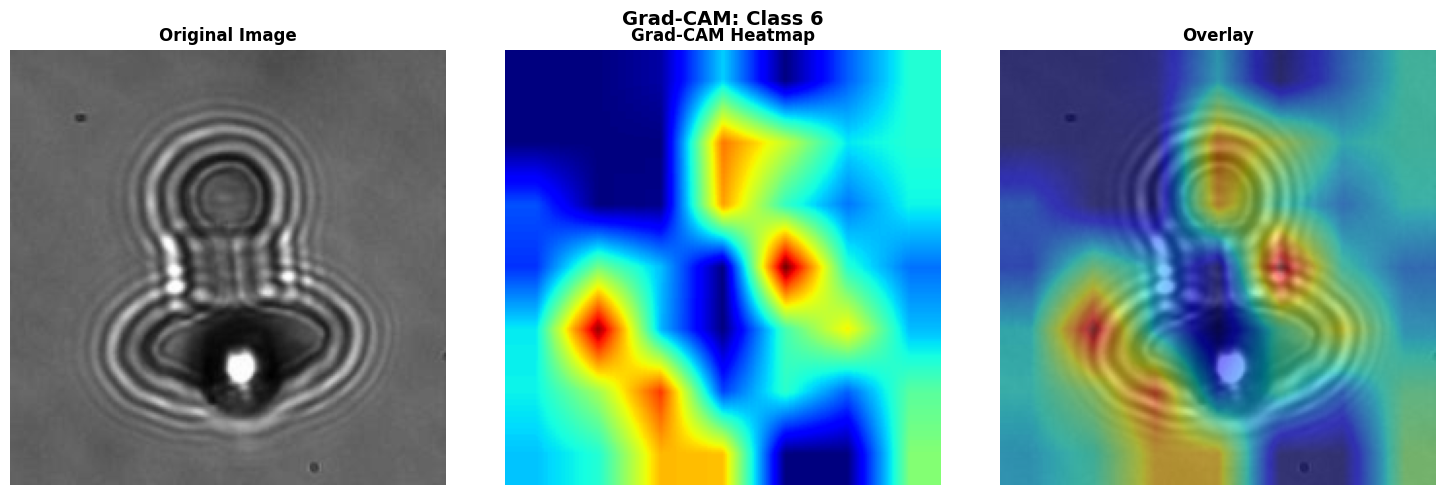

  Sample 6: True=P15/R0, Pred=P15/R0, Conf=0.983


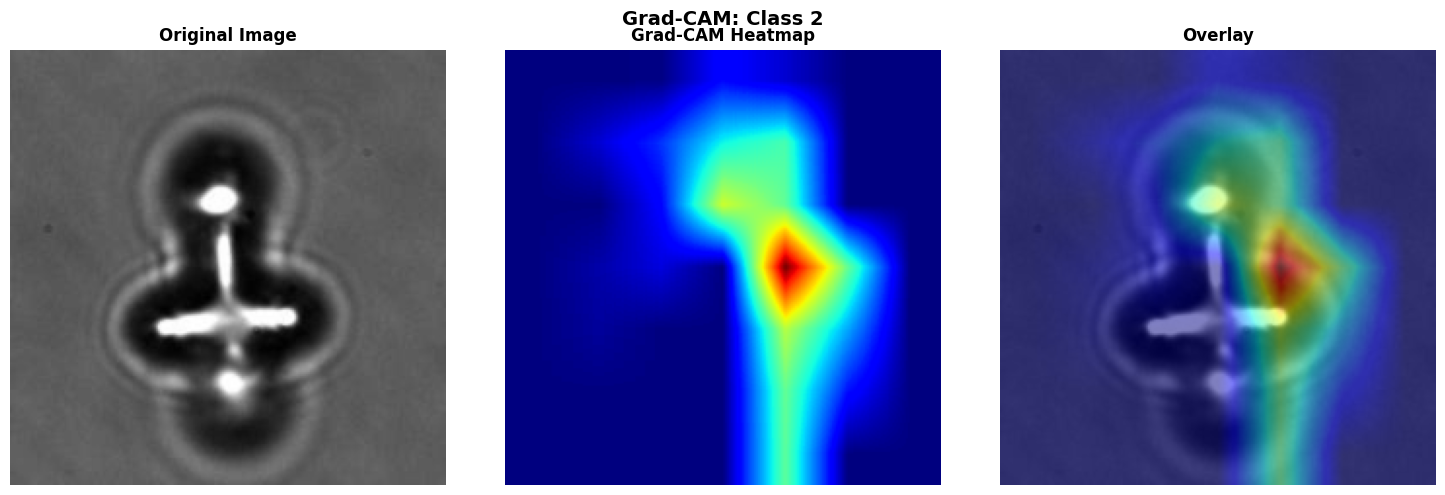


Grad-CAM visualizations created for 6 samples
   Heatmaps show which regions the model focuses on for predictions


In [88]:
# Use plot_grad_cam utility for attention visualization
from src.utils import plot_grad_cam

# Visualize Grad-CAM for multiple samples
n_samples = 6

print(f"Generating Grad-CAM visualizations for {n_samples} samples...")

for i in range(n_samples):
    sample_img, (sample_pitch, sample_roll) = test_dataset[test_idx[i]]
    sample_img_batch = sample_img.unsqueeze(0).to(device)

    # Get labels
    true_pitch = pitch_names[test_predictions['pitch_labels'][i]]
    true_roll = roll_names[test_predictions['roll_labels'][i]]
    pred_pitch = pitch_names[test_predictions['pitch_preds'][i]]
    pred_roll = roll_names[test_predictions['roll_preds'][i]]
    conf = test_predictions['pitch_probs'][i].max()

    # Generate Grad-CAM (using last stage of ConvNeXt-V2)
    print(f"  Sample {i+1}: True={true_pitch}/{true_roll}, Pred={pred_pitch}/{pred_roll}, Conf={conf:.3f}")

    plot_grad_cam(
        model=baseline_model,
        image=sample_img_batch,
        target_layer_name='backbone.stages.3',  # Last stage of ConvNeXt-V2
        class_idx=test_predictions['pitch_labels'][i],
        device=device,
        save_path=project_root / 'reports' / f'4_convnextv2_gradcam_sample_{i}.png'
    )

print(f"\nGrad-CAM visualizations created for {n_samples} samples")
print("   Heatmaps show which regions the model focuses on for predictions")

### 7.7 Embedding Space Visualization (t-SNE)

Extracting learned feature embeddings...
Embeddings shape: (400, 768)
Number of samples: 400
Feature dimension: 768


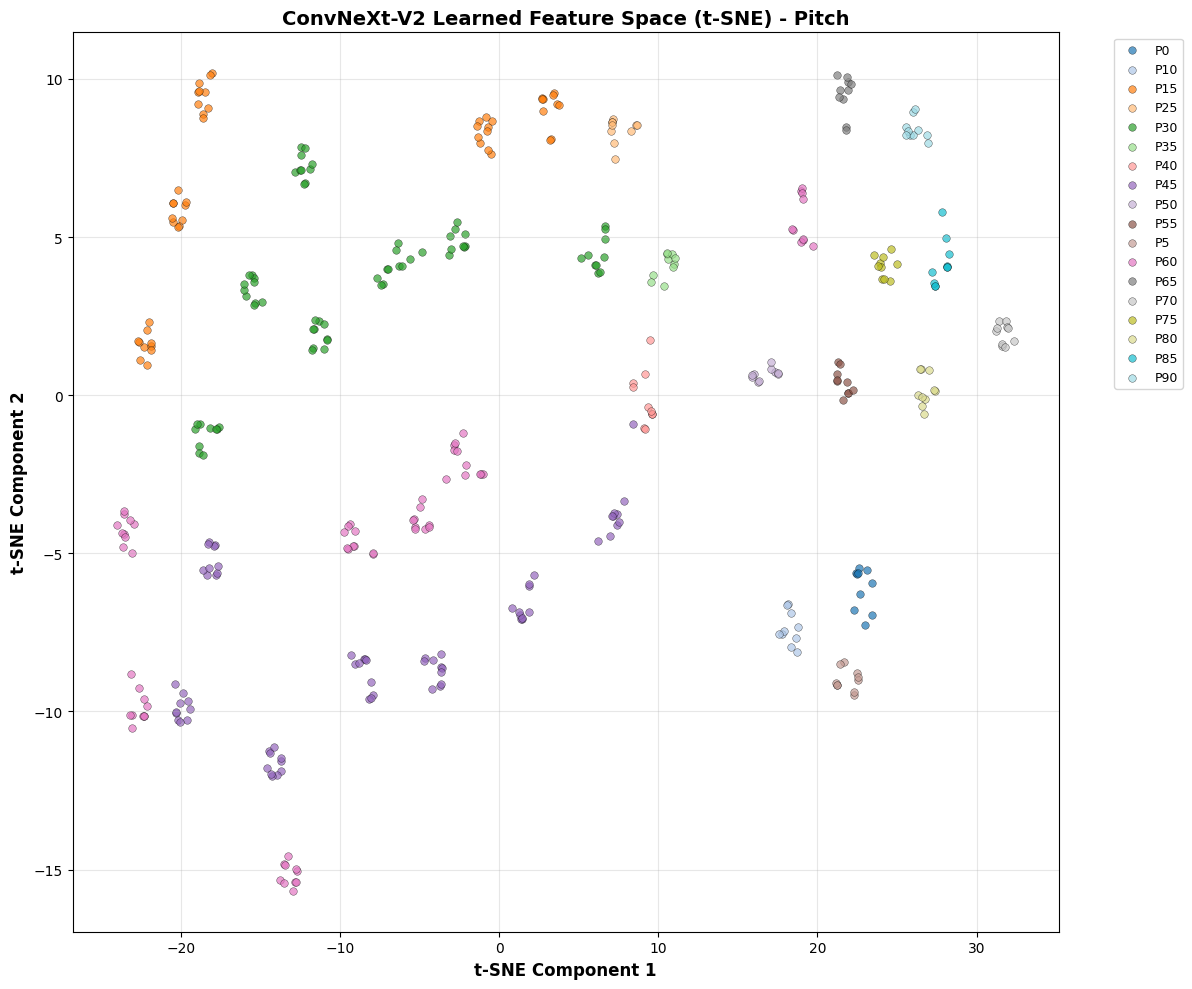


t-SNE embedding visualization created (Pitch)
   This shows how the model organizes images in its learned feature space


In [90]:
# Extract learned features from the model
import numpy as np

print("Extracting learned feature embeddings...")

baseline_model.eval()
embeddings_list = []
pitch_labels_list = []
roll_labels_list = []

with torch.no_grad():
    for batch_idx, (images, (a)) in enumerate(test_loader):
        images = images.to(device)

        # Forward pass and get features before classification heads
        pitch_out, roll_out, features = baseline_model(images, return_features=True)

        embeddings_list.append(features.cpu().numpy())
        pitch_labels_list.append(a["pitch"].cpu().numpy())
        roll_labels_list.append(a["roll"].cpu().numpy())

# Concatenate all batches
embeddings = np.concatenate(embeddings_list, axis=0)
pitch_labels_all = np.concatenate(pitch_labels_list, axis=0)
roll_labels_all = np.concatenate(roll_labels_list, axis=0)

print(f"Embeddings shape: {embeddings.shape}")
print(f"Number of samples: {len(embeddings)}")
print(f"Feature dimension: {embeddings.shape[1]}")

# Use plot_embedding_tsne utility
from src.utils import plot_embedding_tsne

plot_embedding_tsne(
    features=embeddings,
    labels=pitch_labels_all,
    label_names=pitch_names,
    save_path=project_root / 'reports' / '4_convnextv2_tsne_embeddings.png',
    title='ConvNeXt-V2 Learned Feature Space (t-SNE) - Pitch'
)

print("\nt-SNE embedding visualization created (Pitch)")
print("   This shows how the model organizes images in its learned feature space")

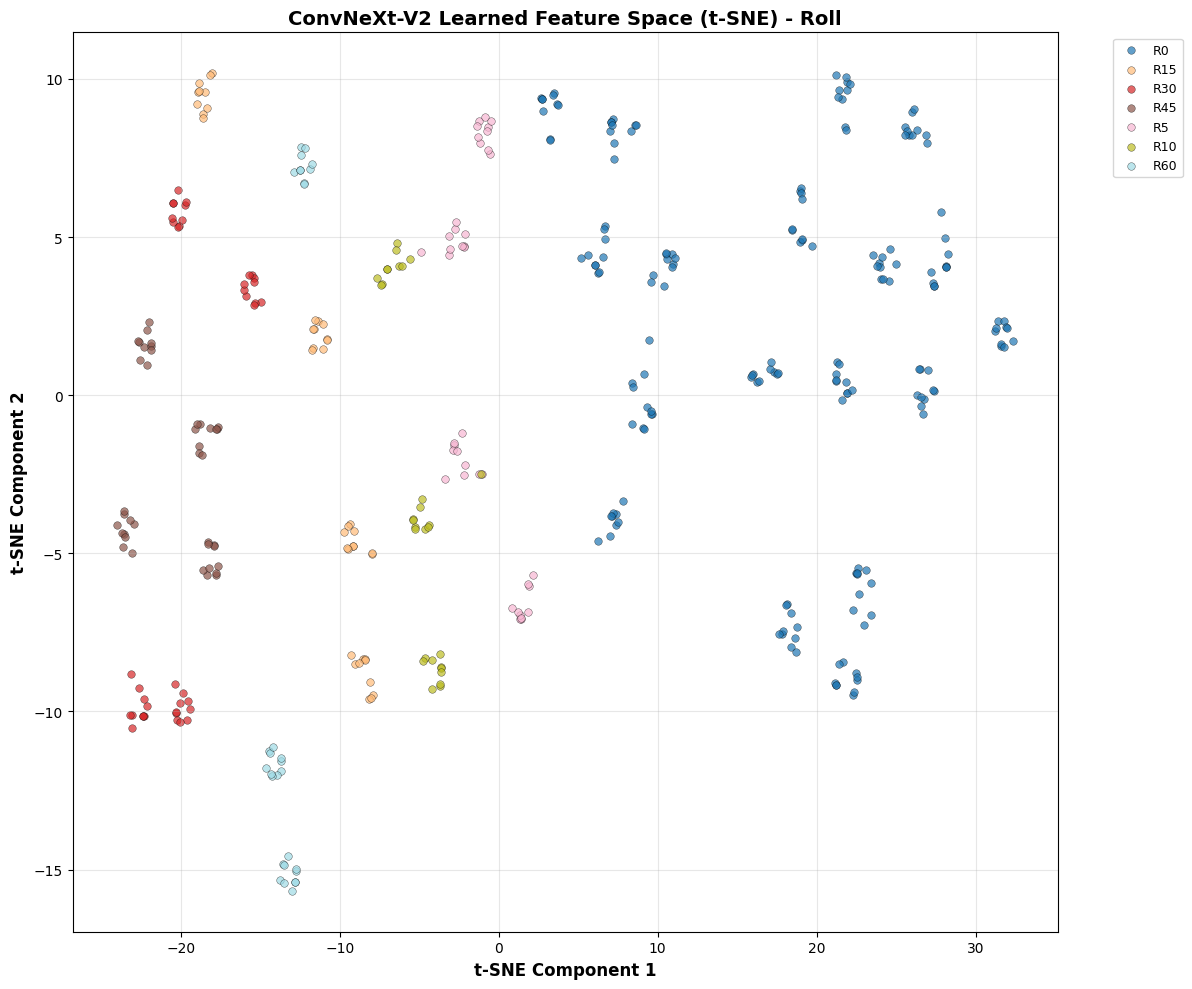


t-SNE embedding visualization created (Roll)


In [91]:
plot_embedding_tsne(
    features=embeddings,
    labels=roll_labels_all,
    label_names=roll_names,
    save_path=project_root / 'reports' / '4_convnextv2_tsne_embeddings_roll.png',
    title='ConvNeXt-V2 Learned Feature Space (t-SNE) - Roll'
)

print("\nt-SNE embedding visualization created (Roll)")

Creating alternative t-SNE visualization with perplexity=50...


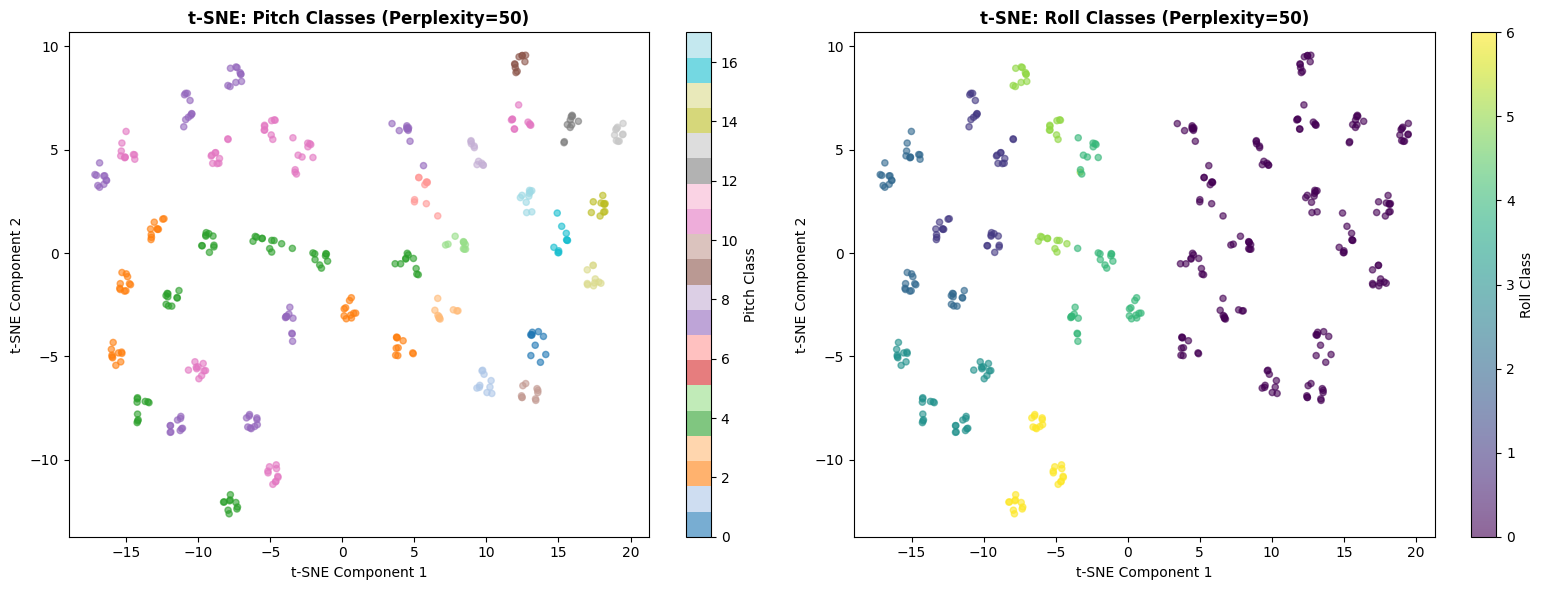

Alternative t-SNE visualization created


In [92]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Alternative t-SNE visualization with different perplexity
print("Creating alternative t-SNE visualization with perplexity=50...")

tsne = TSNE(n_components=2, perplexity=50, random_state=42, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pitch visualization
scatter = axes[0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                         c=pitch_labels_all, cmap='tab20', alpha=0.6, s=20)
axes[0].set_title('t-SNE: Pitch Classes (Perplexity=50)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
plt.colorbar(scatter, ax=axes[0], label='Pitch Class')

# Roll visualization
scatter = axes[1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                         c=roll_labels_all, cmap='viridis', alpha=0.6, s=20)
axes[1].set_title('t-SNE: Roll Classes (Perplexity=50)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
plt.colorbar(scatter, ax=axes[1], label='Roll Class')

plt.tight_layout()
plt.savefig(project_root / 'reports' / '4_convnextv2_tsne_alternative.png', dpi=300, bbox_inches='tight')
plt.show()

print("Alternative t-SNE visualization created")